<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/autoencoders/Vanilla_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will contain the description and code for various type of Autoencoders.

## Dataset

we are going to use an anime face dataset and our aim is to generate or reproduce anime faces

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
''' Link to explain how to download Datasets from kaggle https://www.kaggle.com/general/74235'''
!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/My Drive/Kaggle/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
%%time
!kaggle datasets download -d splcher/animefacedataset -p dataset
!unzip -q dataset/animefacedataset.zip -d dataset/animefacedataset
!rm dataset/animefacedataset.zip

 97% 383M/395M [00:02<00:00, 189MB/s]
100% 395M/395M [00:02<00:00, 145MB/s]
replace dataset/animefacedataset/images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
CPU times: user 86.5 ms, sys: 31.2 ms, total: 118 ms
Wall time: 10.8 s


In [4]:
import os

dataset_dir = "dataset/animefacedataset/images"
image_files = [os.path.join(dataset_dir, x) for x in os.listdir(dataset_dir)] 
len(image_files)

63565

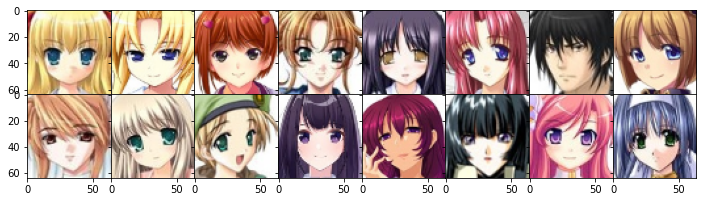

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import math
import cv2

def plot_images(images):
  n_col = 8
  n_row = int(math.ceil(len(images) / n_col))
  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax in zip(images, axs):
      if os.path.exists(img):
          img = cv2.imread(img)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ax.imshow(img)
  plt.show()

from mpl_toolkits.axes_grid1 import ImageGrid
def plot_images(images, n_col=8):
  n_row = int(math.ceil(len(images) / n_col))
  fig = plt.figure(figsize=(12., 12.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )

  for ax, img in zip(grid, images):
      # Iterating over the grid returns the Axes.
      if type(img) == str and os.path.exists(img):
          img = cv2.imread(img)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, (64, 64))  # Reshaping for visualization
      ax.imshow(img)
  plt.show()
plot_images(image_files[0:16])

In [6]:
from sklearn.model_selection import train_test_split
images_files_train, images_files_test = train_test_split(image_files, test_size=0.3, shuffle=True)

print("Train:", len(images_files_train))
print("Test:", len(images_files_test))

Train: 44495
Test: 19070


In [7]:
def read_image_file(imgfile):
  img = cv2.imread(imgfile)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64, 64))  # Reshaping for visualization
  return img.astype(np.uint8)

In [8]:
images_train = np.array([read_image_file(x) for x in images_files_train])
images_train.shape

(44495, 64, 64, 3)

In [9]:
images_test = np.array([read_image_file(x) for x in images_files_test])
images_test.shape

(19070, 64, 64, 3)

In [10]:
images_shape = images_test[0].shape
total_pixels = np.size(images_test[0])
images_shape, total_pixels

((64, 64, 3), 12288)

## Autoencoder - DNN

These type of autoencoders contains dense layers as encoder and decoder

Lets try to build an autoencoder using only dense layers to reproduce same input image




### Training

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

model_file = 'model_ae_dnn.h5'

model = keras.Sequential(name="my_sequential")
model.add(keras.Input(shape=images_shape, dtype=tf.int8))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu", name="encoder_layer_1"))
model.add(layers.Dense(64, activation="relu", name="encoder_layer_2"))
model.add(layers.Dense(32, activation="relu", name="encoder_layer_3"))
model.add(layers.Dense(16, activation="relu", name="encoder_layer_4"))

model.add(layers.Dense(8, name="code"))

model.add(layers.Dense(16, activation="relu", name="decoder_layer_1"))
model.add(layers.Dense(32, activation="relu", name="decoder_layer_2"))
model.add(layers.Dense(64, activation="relu", name="decoder_layer_3"))
model.add(layers.Dense(128, activation="relu", name="decoder_layer_4"))

model.add(layers.Dense(total_pixels, activation="relu", name="final_layer"))
model.add(layers.Reshape(images_shape))

checkpoint = ModelCheckpoint(model_file, verbose=0, monitor='val_loss', save_best_only=True, mode='auto')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# tf.keras.losses.MeanAbsoluteError()
# tf.keras.losses.MeanSquaredError()
# tf.keras.losses.kullback_leibler_divergence()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mse']
              )
model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 12288)             0         
_________________________________________________________________
encoder_layer_1 (Dense)      (None, 128)               1572992   
_________________________________________________________________
encoder_layer_2 (Dense)      (None, 64)                8256      
_________________________________________________________________
encoder_layer_3 (Dense)      (None, 32)                2080      
_________________________________________________________________
encoder_layer_4 (Dense)      (None, 16)                528       
_________________________________________________________________
code (Dense)                 (None, 8)                 136       
_________________________________________________________________
decoder_layer_1 (Dense)      (None, 16)              

In [68]:
%%time
model.fit(images_train, images_train, batch_size=16, epochs=500, validation_split=0.2, callbacks=[checkpoint, early_stopping], shuffle=True)
model.save(model_file) # Save Best model to disk

Epoch 1/500
2225/2225 [==============================] - 16s 7ms/step - loss: 7745.4814 - mse: 7745.4814 - val_loss: 5789.5469 - val_mse: 5789.5469
Epoch 2/500
2225/2225 [==============================] - 15s 7ms/step - loss: 5094.6670 - mse: 5094.6670 - val_loss: 4754.9946 - val_mse: 4754.9946
Epoch 3/500
2225/2225 [==============================] - 15s 7ms/step - loss: 4244.2397 - mse: 4244.2397 - val_loss: 4173.7920 - val_mse: 4173.7920
Epoch 4/500
2225/2225 [==============================] - 15s 7ms/step - loss: 3777.8196 - mse: 3777.8196 - val_loss: 3882.5774 - val_mse: 3882.5774
Epoch 5/500
2225/2225 [==============================] - 15s 7ms/step - loss: 3416.8728 - mse: 3416.8728 - val_loss: 3642.4468 - val_mse: 3642.4468
Epoch 6/500
2225/2225 [==============================] - 15s 7ms/step - loss: 3163.1895 - mse: 3163.1895 - val_loss: 3392.8254 - val_mse: 3392.8254
Epoch 7/500
2225/2225 [==============================] - 15s 7ms/step - loss: 3011.4729 - mse: 3011.4729 - val_l

In [69]:
!mkdir -p drive/MyDrive/datasets/autoencoder/models_animefaces
!cp model_ae_dnn.h5 drive/MyDrive/datasets/autoencoder/models_animefaces
!ls -lh drive/MyDrive/datasets/autoencoder/models_animefaces

total 74M
-rw------- 1 root root 6.0M Jun  5 13:22 model_ae_cnn.h5
-rw------- 1 root root  37M Jun  5 14:56 model_ae_dnn.h5
-rw------- 1 root root  31M Jun  5 10:41 model_ae_lstm.h5


In [58]:
model_file = '/content/drive/MyDrive/datasets/autoencoder/models_animefaces/model_ae_dnn.h5'
# model.load_weights(model_file)  # Load best model
model = tf.keras.models.load_model(model_file) # Load entire model

In [70]:
model.evaluate(images_test, images_test, batch_size=8, verbose=True)

2384/2384 [==============================] - 7s 3ms/step - loss: 2376.7542 - mse: 2376.7542


[2376.754150390625, 2376.754150390625]

=================================== Train Output ===============================


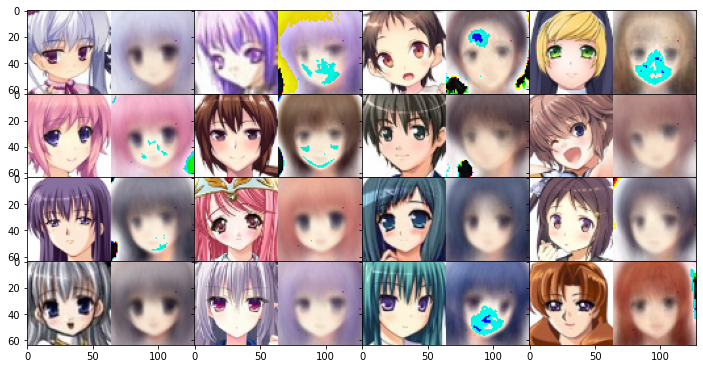

=================================== Prediction Output ===============================


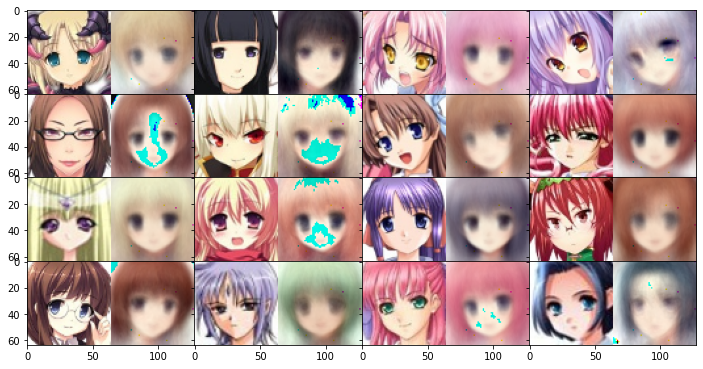

In [71]:
def display_accuracy(model, image_actual, n_col=4, text=""):
  print("=================================== %s ===============================" % text)
  image_generated = model.predict(image_actual, batch_size=8, verbose=False).astype(np.uint8)
  image_generated[image_generated > 255] = 255
  image_generated[image_generated < 0] = 0

  images_side_by_side = np.concatenate([image_actual, image_generated], axis=2)
  plot_images(images_side_by_side, n_col=n_col)

images_to_display = 16
display_accuracy(model, images_train[:images_to_display], text="Train Output")
display_accuracy(model, images_test[:images_to_display], text="Prediction Output")

### Code value - Intermediate representation of image


In [72]:
from tensorflow import keras

# Layers to be used
layers = [keras.Input(shape=images_shape, dtype=tf.int8)]
layers.extend(model.layers[:6])

model_code_generator = keras.Sequential(layers)
model_code_generator.build((None, images_shape[0], images_shape[1], images_shape[2]))

for layer in model_code_generator.layers:
  if list(filter(lambda x: x in layer.name, ['flatten', 'reshape'])):
    continue
  assert all([np.array_equal(layer.get_weights()[0], model.get_layer(layer.name).get_weights()[0]), 
              np.array_equal(layer.get_weights()[1], model.get_layer(layer.name).get_weights()[1])]),  "%s weights not same" % layer.name

model_code_generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 12288)             0         
_________________________________________________________________
encoder_layer_1 (Dense)      (None, 128)               1572992   
_________________________________________________________________
encoder_layer_2 (Dense)      (None, 64)                8256      
_________________________________________________________________
encoder_layer_3 (Dense)      (None, 32)                2080      
_________________________________________________________________
encoder_layer_4 (Dense)      (None, 16)                528       
_________________________________________________________________
code (Dense)                 (None, 8)                 136       
Total params: 1,583,992
Trainable params: 1,583,992
Non-trainable params: 0
____________________________________________

In [73]:
# imgs = model_code_generator.predict(images_test[:4], batch_size=8, verbose=False).astype(np.uint8)
# plot_images(imgs, n_col=8)
# imgs = model.predict(images_test[:4], batch_size=8, verbose=False).astype(np.uint8)
# plot_images(imgs, n_col=8)

In [74]:
codes = model_code_generator.predict(images_test[:16], batch_size=8, verbose=False)
codes.shape

(16, 8)

In [75]:
print(codes[0].tolist())
print(codes[1].tolist())
print(codes[2].tolist())

[1215.6807861328125, 1890.59423828125, -1772.0360107421875, 381.75714111328125, -574.5813598632812, 311.3032531738281, -895.1006469726562, 616.4902954101562]
[-1336.106689453125, -1303.230712890625, -1296.32275390625, 246.3556671142578, -646.2127075195312, -150.3787384033203, -323.1648864746094, -382.8296813964844]
[703.5673217773438, 599.2479858398438, -926.3267822265625, -22.82808494567871, -1733.0594482421875, 1482.5084228515625, -673.0850219726562, -205.01351928710938]


In [76]:
code_stats = { 
    "min" : np.min(codes), 
    "max" : np.max(codes), 
    "mean": np.mean(codes),
    "std": np.std(codes)
}
code_stats

{'max': 2597.495, 'mean': -68.190186, 'min': -3308.1372, 'std': 1030.903}

### Lets generate some random images

But we need to remove some extra layers before that, now we know that code layer has 8 neurons. So we are going to generate some random 8 numbers and will pass it to out decoder layer

In [77]:
import tensorflow as tf
model_file = '/content/drive/MyDrive/datasets/autoencoder/models_animefaces/model_ae_dnn.h5'
model = tf.keras.models.load_model(model_file) # Load entire model
# model.summary()

In [78]:
from tensorflow import keras
model_generator = keras.Sequential(model.layers[6:])
model_generator.build((None, 8))
model_generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_layer_1 (Dense)      (None, 16)                144       
_________________________________________________________________
decoder_layer_2 (Dense)      (None, 32)                544       
_________________________________________________________________
decoder_layer_3 (Dense)      (None, 64)                2112      
_________________________________________________________________
decoder_layer_4 (Dense)      (None, 128)               8320      
_________________________________________________________________
final_layer (Dense)          (None, 12288)             1585152   
_________________________________________________________________
reshape_9 (Reshape)          (None, 64, 64, 3)         0         
Total params: 1,596,272
Trainable params: 1,596,272
Non-trainable params: 0
____________________________________________

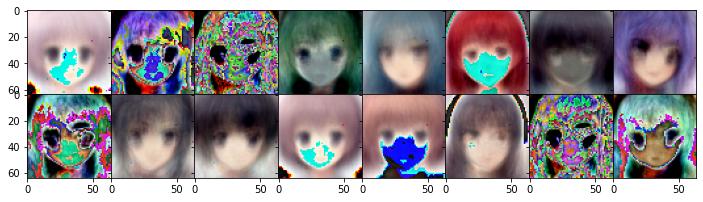

In [81]:
import numpy as np
inputs  = np.random.normal(code_stats['mean'], code_stats['std'], (16, 8))
# inputs = codes
image_generated = model_generator.predict(inputs, batch_size=8, verbose=False).astype(np.uint8)
image_generated[image_generated > 255] = 255
image_generated[image_generated < 0] = 0
plot_images(image_generated, n_col=8)

## Autoencoder - LSTM

This would be similar to Dense n/w as desribed above, but we will use LSTM layers this time

### Training

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

model_file = 'model_ae_lstm.h5'

model = keras.Sequential(name="my_sequential")
model.add(tf.keras.layers.InputLayer(input_shape=images_shape))
model.add(layers.Reshape((images_shape[0], images_shape[1] * images_shape[2])))
model.add(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, name="encoder_layer_1"))
model.add(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True, name="encoder_layer_2"))
model.add(tf.keras.layers.LSTM(16, activation='tanh', name="encoder_layer_3"))

model.add(layers.Dense(8, name="code"))
model.add(layers.Reshape((2, 4)))

model.add(tf.keras.layers.LSTM(16, activation='tanh', return_sequences=True, name="decoder_layer_1"))
model.add(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True, name="decoder_layer_2"))
model.add(tf.keras.layers.LSTM(64, activation='tanh', name="decoder_layer_3"))
model.add(layers.Dense(total_pixels, activation="relu", name="final_layer"))
model.add(layers.Reshape(images_shape))

checkpoint = ModelCheckpoint(model_file, verbose=0, monitor='val_loss', save_best_only=True, mode='auto')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mse']
              )
model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 192)           0         
_________________________________________________________________
encoder_layer_1 (LSTM)       (None, 64, 64)            65792     
_________________________________________________________________
encoder_layer_2 (LSTM)       (None, 64, 32)            12416     
_________________________________________________________________
encoder_layer_3 (LSTM)       (None, 16)                3136      
_________________________________________________________________
code (Dense)                 (None, 8)                 136       
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 4)              0         
_________________________________________________________________
decoder_layer_1 (LSTM)       (None, 2, 16)           

In [12]:
%%time
model.fit(images_train, images_train, batch_size=16, epochs=500, validation_split=0.2, callbacks=[checkpoint, early_stopping], shuffle=True)
model.save(model_file) # Save Best model to disk

Epoch 1/500
2225/2225 [==============================] - 47s 15ms/step - loss: 17278.6152 - mse: 17278.6152 - val_loss: 10705.0771 - val_mse: 10705.0771
Epoch 2/500
2225/2225 [==============================] - 33s 15ms/step - loss: 9260.0801 - mse: 9260.0801 - val_loss: 8613.3975 - val_mse: 8613.3975
Epoch 3/500
2225/2225 [==============================] - 33s 15ms/step - loss: 8594.0107 - mse: 8594.0107 - val_loss: 8547.8838 - val_mse: 8547.8838
Epoch 4/500
2225/2225 [==============================] - 33s 15ms/step - loss: 8581.1357 - mse: 8581.1357 - val_loss: 8547.7734 - val_mse: 8547.7734
Epoch 5/500
2225/2225 [==============================] - 32s 14ms/step - loss: 8581.2842 - mse: 8581.2842 - val_loss: 8547.7871 - val_mse: 8547.7871
Epoch 6/500
2225/2225 [==============================] - 32s 14ms/step - loss: 8581.1934 - mse: 8581.1934 - val_loss: 8547.9473 - val_mse: 8547.9473
Epoch 7/500
2225/2225 [==============================] - 32s 14ms/step - loss: 8576.4355 - mse: 8576.4

In [13]:
!mkdir -p drive/MyDrive/datasets/autoencoder/models_animefaces
!cp model_ae_lstm.h5 drive/MyDrive/datasets/autoencoder/models_animefaces
!ls -lh drive/MyDrive/datasets/autoencoder/models_animefaces

total 53M
-rw------- 1 root root 6.0M Jun  5 13:22 model_ae_cnn.h5
-rw------- 1 root root  37M Jun  5 14:56 model_ae_dnn.h5
-rw------- 1 root root  11M Jun  6 07:45 model_ae_lstm.h5


In [14]:
# model_file = '/content/drive/MyDrive/datasets/autoencoder/models_animefaces/model_ae_lstm.h5'
# model.load_weights(model_file)  # Load best model
model = tf.keras.models.load_model(model_file) # Load entire model

In [15]:
model.evaluate(images_test, images_test, batch_size=8, verbose=True)

2384/2384 [==============================] - 17s 6ms/step - loss: 2092.5908 - mse: 2092.5908


[2092.5908203125, 2092.5908203125]

=================================== Train Output ===============================


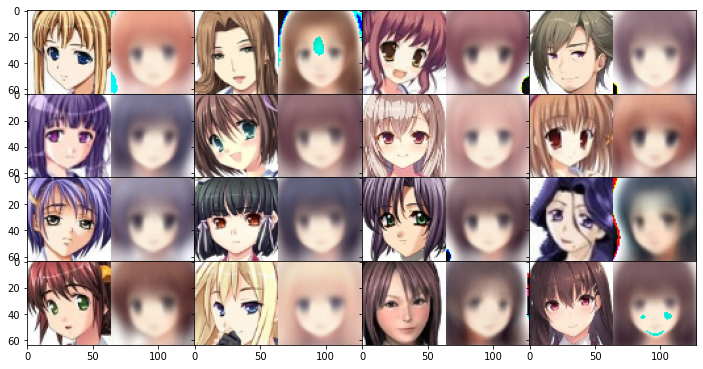

=================================== Prediction Output ===============================


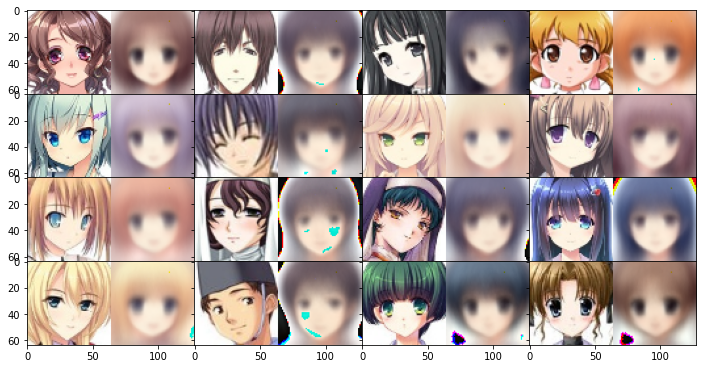

In [16]:
def display_accuracy(model, image_actual, n_col=4, text=""):
  print("=================================== %s ===============================" % text)
  image_generated = model.predict(image_actual, batch_size=8, verbose=False).astype(np.uint8)
  image_generated[image_generated > 255] = 255
  image_generated[image_generated < 0] = 0

  images_side_by_side = np.concatenate([image_actual, image_generated], axis=2)
  plot_images(images_side_by_side, n_col=n_col)

images_to_display = 16
display_accuracy(model, images_train[:images_to_display], text="Train Output")
display_accuracy(model, images_test[:images_to_display], text="Prediction Output")

### Code value - Intermediate representation of image


In [20]:
from tensorflow import keras

# Layers to be used
layers = [tf.keras.layers.InputLayer(input_shape=images_shape)]
layers.extend(model.layers[:5])

model_code_generator = keras.Sequential(layers)
model_code_generator.build((None, images_shape[0], images_shape[1], images_shape[2]))

for layer in model_code_generator.layers:
  if list(filter(lambda x: x in layer.name, ['flatten', 'reshape'])):
    continue
  assert all([np.array_equal(layer.get_weights()[0], model.get_layer(layer.name).get_weights()[0]), 
              np.array_equal(layer.get_weights()[1], model.get_layer(layer.name).get_weights()[1])]),  "%s weights not same" % layer.name

model_code_generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 192)           0         
_________________________________________________________________
encoder_layer_1 (LSTM)       (None, 64, 64)            65792     
_________________________________________________________________
encoder_layer_2 (LSTM)       (None, 64, 32)            12416     
_________________________________________________________________
encoder_layer_3 (LSTM)       (None, 16)                3136      
_________________________________________________________________
code (Dense)                 (None, 8)                 136       
Total params: 81,480
Trainable params: 81,480
Non-trainable params: 0
_________________________________________________________________


In [21]:
codes = model_code_generator.predict(images_test[:16], batch_size=8, verbose=False)
codes.shape

(16, 8)

In [22]:
print(codes[0].tolist())
print(codes[1].tolist())
print(codes[2].tolist())

[-0.26205557584762573, -0.33697181940078735, -0.3860102891921997, 0.07216334342956543, -0.08162796497344971, 0.21333178877830505, 0.44444242119789124, -0.7647983431816101]
[-0.411038339138031, 0.4667309522628784, -0.6031712293624878, -0.2982359230518341, 0.4706922173500061, -0.06073388457298279, -0.12359648942947388, 0.189530611038208]
[-0.05309383571147919, -0.9304435849189758, -0.7033981680870056, -0.44504719972610474, -0.6713100671768188, 1.3494720458984375, -0.4281803071498871, -0.707094132900238]


In [23]:
code_stats = { 
    "min" : np.min(codes), 
    "max" : np.max(codes), 
    "mean": np.mean(codes),
    "std": np.std(codes)
}
code_stats

{'max': 1.349472, 'mean': -0.058297068, 'min': -1.4627534, 'std': 0.5171938}

### Lets generate some random images

But we need to remove some extra layers before that, now we know that code layer has 8 neurons. So we are going to generate some random 8 numbers and will pass it to out decoder layer

In [24]:
import tensorflow as tf
model_file = '/content/drive/MyDrive/datasets/autoencoder/models_animefaces/model_ae_lstm.h5'
model = tf.keras.models.load_model(model_file) # Load entire model
# model.summary()

In [26]:
from tensorflow import keras
model_generator = keras.Sequential(model.layers[5:])
model_generator.build((None, 8))
model_generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 4)              0         
_________________________________________________________________
decoder_layer_1 (LSTM)       (None, 2, 16)             1344      
_________________________________________________________________
decoder_layer_2 (LSTM)       (None, 2, 32)             6272      
_________________________________________________________________
decoder_layer_3 (LSTM)       (None, 64)                24832     
_________________________________________________________________
final_layer (Dense)          (None, 12288)             798720    
_________________________________________________________________
reshape_2 (Reshape)          (None, 64, 64, 3)         0         
Total params: 831,168
Trainable params: 831,168
Non-trainable params: 0
________________________________________________

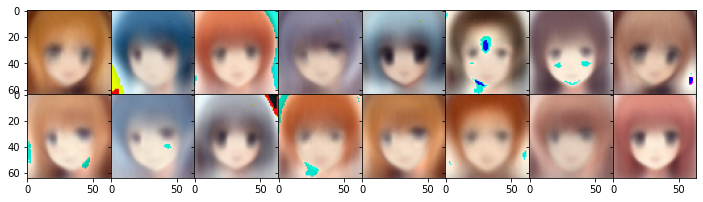

In [30]:
import numpy as np
inputs  = np.random.normal(code_stats['mean'], code_stats['std'], (16, 8))
# inputs = codes
image_generated = model_generator.predict(inputs, batch_size=8, verbose=False).astype(np.uint8)
image_generated[image_generated > 255] = 255
image_generated[image_generated < 0] = 0
plot_images(image_generated, n_col=8)

## Autoencoder - CNN

This would be similar to Dense n/w as desribed above, but we will use CNN layers this time

### Training

In [13]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

model_file = 'model_ae_cnn.h5'

filter_size = (3, 3)
model = keras.Sequential(name="autoencoder_cnn")

model.add(tf.keras.layers.InputLayer(input_shape=images_shape))
# model.add(tf.keras.layers.Conv2D(256, filter_size, activation='relu', padding='same', strides=2, name='encoder_layer_1'))
model.add(tf.keras.layers.Conv2D(128, filter_size, activation='relu', padding='same', strides=2, name='encoder_layer_1'))
model.add(tf.keras.layers.Conv2D(64, filter_size, activation='relu', padding='same', strides=2, name='encoder_layer_2'))
model.add(tf.keras.layers.Conv2D(32, filter_size, activation='relu', padding='same', strides=2, name='encoder_layer_3'))
model.add(tf.keras.layers.Conv2D(16, filter_size, activation='relu', padding='same', strides=2, name='encoder_layer_4'))

model.add(layers.Flatten())
model.add(layers.Dense(8, name="code"))
model.add(layers.Reshape((2, 2, 2)))

model.add(tf.keras.layers.Conv2DTranspose(16, filter_size, activation='relu', padding='same', strides=2, name='decoder_layer_1'))
model.add(tf.keras.layers.Conv2DTranspose(32, filter_size, activation='relu', padding='same', strides=2, name='decoder_layer_2'))
model.add(tf.keras.layers.Conv2DTranspose(64, filter_size, activation='relu', padding='same', strides=2, name='decoder_layer_3'))
model.add(tf.keras.layers.Conv2DTranspose(128, filter_size, activation='relu', padding='same', strides=2, name='decoder_layer_4'))
# model.add(tf.keras.layers.Conv2DTranspose(256, filter_size, activation='relu', padding='same', strides=2, name='decoder_layer_5'))

model.add(tf.keras.layers.Conv2DTranspose(3, filter_size, activation='relu', padding='same', strides=2, name='decoder_layer_6'))

checkpoint = ModelCheckpoint(model_file, verbose=0, monitor='val_loss', save_best_only=True, mode='auto')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['mse']
              )
model.summary()

Model: "autoencoder_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_layer_1 (Conv2D)     (None, 32, 32, 128)       3584      
_________________________________________________________________
encoder_layer_2 (Conv2D)     (None, 16, 16, 64)        73792     
_________________________________________________________________
encoder_layer_3 (Conv2D)     (None, 8, 8, 32)          18464     
_________________________________________________________________
encoder_layer_4 (Conv2D)     (None, 4, 4, 16)          4624      
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
code (Dense)                 (None, 8)                 2056      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 2)       

In [39]:
%%time
model.fit(images_train, images_train, batch_size=32, epochs=500, validation_split=0.2, callbacks=[checkpoint, early_stopping], shuffle=True)
model.save(model_file) # Save Best model to disk

Epoch 1/500
1113/1113 [==============================] - 42s 14ms/step - loss: 3058.9998 - mse: 3058.9998 - val_loss: 2511.7271 - val_mse: 2511.7271
Epoch 2/500
1113/1113 [==============================] - 15s 14ms/step - loss: 2468.7471 - mse: 2468.7471 - val_loss: 2443.8110 - val_mse: 2443.8110
Epoch 3/500
1113/1113 [==============================] - 16s 14ms/step - loss: 2411.2112 - mse: 2411.2112 - val_loss: 2394.8528 - val_mse: 2394.8528
Epoch 4/500
1113/1113 [==============================] - 16s 14ms/step - loss: 2384.5640 - mse: 2384.5640 - val_loss: 2383.0754 - val_mse: 2383.0754
Epoch 5/500
1113/1113 [==============================] - 16s 14ms/step - loss: 2369.5110 - mse: 2369.5110 - val_loss: 2363.0452 - val_mse: 2363.0452
Epoch 6/500
1113/1113 [==============================] - 16s 14ms/step - loss: 2359.4460 - mse: 2359.4460 - val_loss: 2373.9758 - val_mse: 2373.9758
Epoch 7/500
1113/1113 [==============================] - 16s 14ms/step - loss: 2339.5972 - mse: 2339.5972 

In [40]:
!mkdir -p drive/MyDrive/datasets/autoencoder/models_animefaces
!cp model_ae_cnn.h5 drive/MyDrive/datasets/autoencoder/models_animefaces
!ls -lh drive/MyDrive/datasets/autoencoder/models_animefaces

total 50M
-rw------- 1 root root 2.5M Jun  6 08:16 model_ae_cnn.h5
-rw------- 1 root root  37M Jun  5 14:56 model_ae_dnn.h5
-rw------- 1 root root  11M Jun  6 07:45 model_ae_lstm.h5


In [12]:
model_file = '/content/drive/MyDrive/datasets/autoencoder/models_animefaces/model_ae_cnn.h5'
# model.load_weights(model_file)  # Load best model
model = tf.keras.models.load_model(model_file) # Load entire model

In [41]:
model.evaluate(images_test, images_test, batch_size=8, verbose=True)

2384/2384 [==============================] - 10s 4ms/step - loss: 2117.5776 - mse: 2117.5776


[2117.57763671875, 2117.57763671875]

=================================== Train Output ===============================


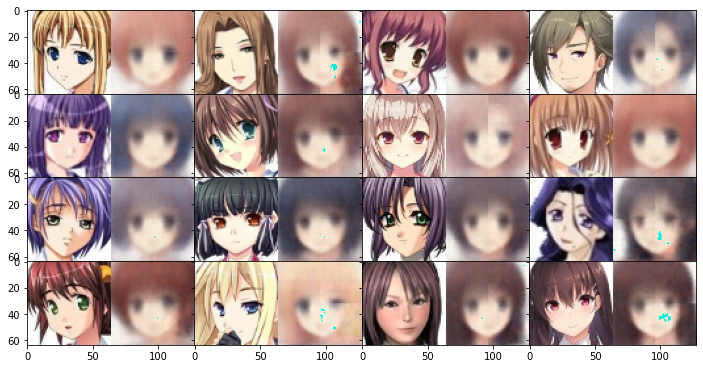

=================================== Prediction Output ===============================


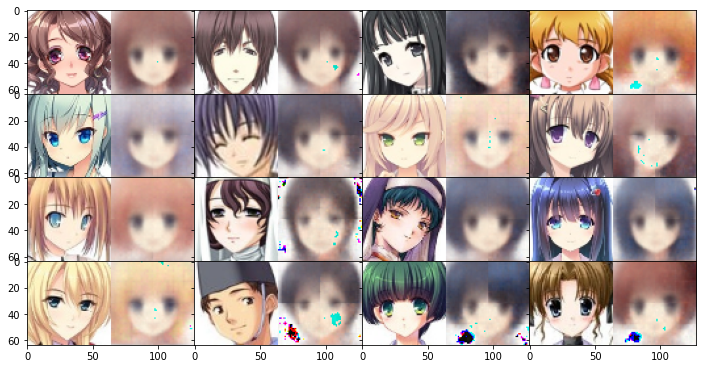

In [42]:
def display_accuracy(model, image_actual, n_col=4, text=""):
  print("=================================== %s ===============================" % text)
  image_generated = model.predict(image_actual, batch_size=8, verbose=False).astype(np.uint8)
  image_generated[image_generated > 255] = 255
  image_generated[image_generated < 0] = 0

  images_side_by_side = np.concatenate([image_actual, image_generated], axis=2)
  plot_images(images_side_by_side, n_col=n_col)

images_to_display = 16
display_accuracy(model, images_train[:images_to_display], text="Train Output")
display_accuracy(model, images_test[:images_to_display], text="Prediction Output")

### Code value - Intermediate representation of image


In [16]:
from tensorflow import keras

# Layers to be used
layers = [tf.keras.layers.InputLayer(input_shape=images_shape)]
layers.extend(model.layers[:6])

model_code_generator = keras.Sequential(layers)
model_code_generator.build((None, images_shape[0], images_shape[1], images_shape[2]))

for layer in model_code_generator.layers:
  if list(filter(lambda x: x in layer.name, ['flatten', 'reshape'])):
    continue
  assert all([np.array_equal(layer.get_weights()[0], model.get_layer(layer.name).get_weights()[0]), 
              np.array_equal(layer.get_weights()[1], model.get_layer(layer.name).get_weights()[1])]),  "%s weights not same" % layer.name

model_code_generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_layer_1 (Conv2D)     (None, 32, 32, 128)       3584      
_________________________________________________________________
encoder_layer_2 (Conv2D)     (None, 16, 16, 64)        73792     
_________________________________________________________________
encoder_layer_3 (Conv2D)     (None, 8, 8, 32)          18464     
_________________________________________________________________
encoder_layer_4 (Conv2D)     (None, 4, 4, 16)          4624      
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
code (Dense)                 (None, 8)                 2056      
Total params: 102,520
Trainable params: 102,520
Non-trainable params: 0
________________________________________________

In [17]:
codes = model_code_generator.predict(images_test[:16], batch_size=8, verbose=False)
codes.shape

(16, 8)

In [18]:
print(codes[0].tolist())
print(codes[1].tolist())
print(codes[2].tolist())

[-90.84349060058594, 78.14624786376953, 61.19371795654297, 47.44902038574219, 135.2177734375, 48.00750732421875, -166.69300842285156, -8.807793617248535]
[-82.30125427246094, 82.98831939697266, 61.37909698486328, 43.42222213745117, 97.01995849609375, 58.46400833129883, -44.247249603271484, 2.3804984092712402]
[-55.21834945678711, 40.70209503173828, 36.956214904785156, 42.93532180786133, 128.26377868652344, 51.0125846862793, -89.1243667602539, -20.50321388244629]


In [19]:
code_stats = { 
    "min" : np.min(codes), 
    "max" : np.max(codes), 
    "mean": np.mean(codes),
    "std": np.std(codes)
}
code_stats

{'max': 136.47034, 'mean': 27.564598, 'min': -187.67128, 'std': 69.36067}

### Lets generate some random images

But we need to remove some extra layers before that, now we know that code layer has 8 neurons. So we are going to generate some random 8 numbers and will pass it to out decoder layer

In [23]:
import tensorflow as tf
model_file = '/content/drive/MyDrive/datasets/autoencoder/models_animefaces/model_ae_cnn.h5'
model = tf.keras.models.load_model(model_file) # Load entire model
# model.summary()

In [25]:
from tensorflow import keras
model_generator = keras.Sequential(model.layers[6:])
model_generator.build((None, 8))
model_generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 2, 2, 2)           0         
_________________________________________________________________
decoder_layer_1 (Conv2DTrans (None, 4, 4, 16)          304       
_________________________________________________________________
decoder_layer_2 (Conv2DTrans (None, 8, 8, 32)          4640      
_________________________________________________________________
decoder_layer_3 (Conv2DTrans (None, 16, 16, 64)        18496     
_________________________________________________________________
decoder_layer_4 (Conv2DTrans (None, 32, 32, 128)       73856     
_________________________________________________________________
decoder_layer_6 (Conv2DTrans (None, 64, 64, 3)         3459      
Total params: 100,755
Trainable params: 100,755
Non-trainable params: 0
________________________________________________

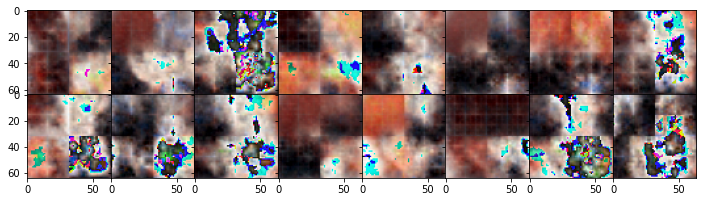

In [55]:
import numpy as np
inputs  = np.random.normal(code_stats['mean'], code_stats['std'], (16, 8))
# inputs = codes
image_generated = model_generator.predict(inputs, batch_size=8, verbose=False).astype(np.uint8)
image_generated[image_generated > 255] = 255
image_generated[image_generated < 0] = 0
plot_images(image_generated, n_col=8)